# Fraud Test data

Data from https://www.kaggle.com/datasets/kartik2112/fraud-detection

------------------ google colab ---------------------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd 'drive/MyDrive/deep-learning/Project'

/content/drive/MyDrive/deep-learning/Project


-------------------------------------------

## 1. Load data

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
'''
data = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
data.shape # (590540, 394)
data.to_pickle('ieee_pickled.pkl')
'''

In [3]:
data = pd.read_pickle('ieee_pickled.pkl')
data.shape # size (590540, 394), second one is label

(590540, 394)

In [4]:
labels = data.iloc[:, 1]
n_positive = sum(labels)
print(n_positive)
print('percent positive = ', n_positive/len(labels))

20663
percent positive =  0.03499000914417313


In [ ]:
#labels = torch.from_numpy(labels.to_numpy()).float()
#torch.save(labels, 'labels.pt')

=================== scratch work ==================<br>
TransactionID is just an index, exclude from analysis.<br>
TransactionDT some kind of time, can process to get month/day. <br>
Day and start_day extracted can be used for userid. <br>

The C columns have no missing values. 

In [53]:
print(data.columns[13:14])

Index(['dist1'], dtype='object')


In [46]:
Dcolumns = [c for c in data.columns if c[0] == 'D']
Ccolumns = [c for c in data.columns if c[0] == 'C']
Mcolumns = [c for c in data.columns if c[0] == 'M']
Vcolumns = [c for c in data.columns if c[0] == 'V']
Cardcolumns = [c for c in data.columns if c.startswith('card')]

In [29]:
data['day']=data['TransactionDT']//(60*60*24)
data['start_date'] = data['day']-data['D1']+10000

### 1.1 (optional) About missing values

In [ ]:
nan_count = data.isna().sum()
plt.plot(nan_count)
plt.yscale('log')
plt.ylabel('number of missing values'), plt.xlabel('features')
plt.show()

In [ ]:
bad_col = data.columns[nan_count> 1e5]
print(bad_col)
good_col = data.columns[nan_count < 100]
print(len(good_col))

there are 19 features with no missing values, 52 features with fewer than 100 missing values, 94 features with fewer than 1000 missing values.<br>
In the case of < 100 missing values, all columns with missing values share the same 12 indices. 2 of these are fraud.<br>
In the case of < 1000 missing values, the missing values lie in 326 different rows. Among these, 19 of them are fraud. This ratio is a bit high.

In [ ]:
total_missing = []
for col in good_col:
    missing_idx = data.index[data[col].isna()].tolist()
    total_missing.extend(missing_idx)

print('number of rows with missing values', len(set(total_missing)))
print('fraudulent', sum(data.isFraud[list(set(total_missing))]))

data_nomissing = data.drop(set(total_missing))
data_label = data_nomissing['isFraud']
data_features = data_nomissing.drop(columns=['isFraud'])

## 2. Preprocessing: split by feature type
Split into numerical and categorial columns.
For categorical, use one hot or 1/0.
For numerical, normalize.

### 2.1 Features

https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203<br>
Transaction table<br>
“It contains money transfer and also other gifting goods and service, like you booked a ticket for others, etc.”

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

TransactionAMT: transaction payment amount in USD
“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

ProductCD: product code, the product for each transaction
“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

addr: address<br>
“both addresses are for purchaser
addr1 as billing region
addr2 as billing country”

dist: distance<br>
"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”

P_ and (R__) emaildomain: purchaser and recipient email domain
“ certain transactions don't need recipient, so R_emaildomain is null.”

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
“Can you please give more examples of counts in the variables C1-15? Would these be like counts of phone numbers, email addresses, names associated with the user? I can't think of 15.
Your guess is good, plus like device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.”

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc.

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”
"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

Identity Table<br>
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

DeviceInfo : https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#583227

“id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.”

col1 and col2 have the same missing values  False
False


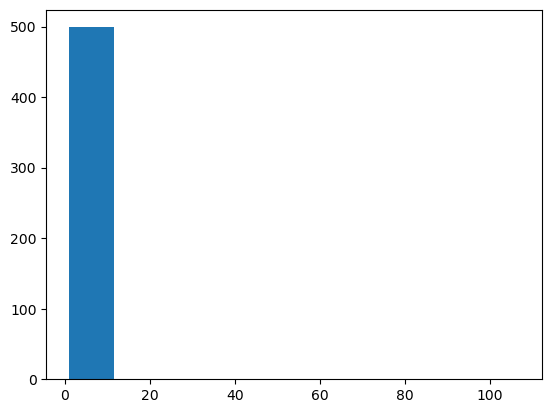

card2
111.0      2
122.0      2
134.0      7
213.0      3
277.0      3
343.0      2
349.0      2
352.0      2
360.0      2
368.0      3
378.0      3
390.0      2
404.0      2
439.0      2
463.0      5
469.0      3
514.0      2
555.0    107
Name: card3, dtype: int64


In [66]:
# compare nested relationship between columns 
col1 = 'card2'
col2 = 'card3'

print('col1 and col2 have the same missing values ', (data[col1].isna() == data[col2].isna()).all()) # addr1 and addr2 have the same missing values
data_cols = data[[col1, col2]]
nested = data_cols.groupby(col1)[col2].nunique()
print((nested ==1).all())
plt.hist(nested)
plt.show()
print(nested[nested!=1]) # some 35 of addr1 are associated with multiple addr2 values. if these are region vs country, maybe error?? 

352271

In [5]:
data_label = data.isFraud
data_features = data.drop(columns=['isFraud'])

# since TransactionDT is an important feature that separates train and test data, it shouldn't be part of training.
# TransactionID is just index
columns_remove = ['TransactionID', 'TransactionDT', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain', 'R_emaildomain', 'addr1', 'addr2', 'dist1', 'dist2']
columns_reduced = [c for c in data_features.columns if c not in columns_remove]
data_features = data_features[columns_reduced]

['TransactionAmt', 'ProductCD', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105

In [11]:
# Numerical columns
num_cols = data_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numerical columns:", num_cols)

# Categorical columns
cat_cols = data_features.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)

Numerical columns: ['TransactionAmt', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111

### 2.1 Preprocessing: categorical features
Among categorical columns, ProductCD has 5 values, card4 has 4, card6 has 4, ------> one hot <br>
P_emaildomain, R_emaildomain have a lot (59 and 60)<br>
M1-M9 except M4 are True False --------> convert to 1/0 <br>
M4 has values M0, M2, M1 ----------> numerical 0, 2, 1

In [ ]:
#for col in cat_cols:
#    print(data[col].nunique())

In [15]:
features_expanded = data_features.copy()

In [16]:
for col in cat_cols:
    if col[0] == 'M':
        if col[1] != 4:
            features_expanded[col] = features_expanded[col].map({'T': 1, 'F': 0})
        else:
            features_expanded[col] = features_expanded[col].map({'M0': 0, 'M1': 1, 'M2':2})
    else:
        features_expanded = pd.get_dummies(features_expanded, columns=[col], dtype=int)

features_expanded.head()

,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,V335,V336,V337,V338,V339,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,68.5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
1,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
2,59.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
3,50.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1
4,50.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


### 2.2 Preprocessing: scaling numerical features

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
features_normalized=features_expanded.copy()
features_normalized[num_cols] = scaler.fit_transform(features_normalized[num_cols])

In [ ]:
features_normalized.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,R_emaildomain_web.de,R_emaildomain_windstream.net,R_emaildomain_yahoo.co.jp,R_emaildomain_yahoo.co.uk,R_emaildomain_yahoo.com,R_emaildomain_yahoo.com.mx,R_emaildomain_yahoo.de,R_emaildomain_yahoo.es,R_emaildomain_yahoo.fr,R_emaildomain_ymail.com
0,0.000000,0.000000e+00,0.002137,0.743044,NaN,0.381679,0.306569,0.488636,0.836957,0.001847,...,0,0,0,0,0,0,0,0,0,0
1,0.000002,6.359409e-08,0.000900,0.100885,0.608,0.381679,0.014599,0.511364,0.836957,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.000003,4.387992e-06,0.001840,0.210566,0.780,0.381679,0.481752,0.522727,0.836957,0.027902,...,0,0,0,0,0,0,0,0,0,0
3,0.000005,6.295815e-06,0.001558,0.984824,0.934,0.381679,0.124088,0.854545,0.836957,NaN,...,0,0,0,0,0,0,0,0,0,0
4,0.000007,6.740974e-06,0.001558,0.201023,0.828,0.381679,0.014599,0.727273,0.836957,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features_normalized = torch.to_numpy(features_normalized.to_numpy()).float()
torch.save(features_normalized, 'features_normalized.pt')

AttributeError: module 'torch' has no attribute 'to_numpy'

## 3. Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
labels = torch.load('labels.pt')
features_normalized = torch.load('features_normalized.pt')

In [ ]:
#print(labels.shape)
#print(features_normalized.shape)

torch.Size([590540])
torch.Size([590540, 520])


In [ ]:
# move to cuda
'''
features_normalized = features_normalized.to(device)
labels = labels.to(device)
features_normalized_cpu = features_normalized.cpu()
labels_cpu = labels.cpu()
'''

### 3.1 Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42,
                                                    stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
mask_val = ~torch.isnan(X_val) # validation set doesn't change so may as well do mask once and for all
X_val_filled = torch.nan_to_num(X_val, nan=0.0)
X_val_filled = X_val_filled.float().to(device) # val data doesn't go through dataloader so it needs to go on gpu separately
mask_val = mask_val.to(device) # Move mask to the correct device as well

In [ ]:
# Convert to torch tensors
mask = ~torch.isnan(X_train)  # True where data is present
X_filled = torch.nan_to_num(X_train, nan=0.0)  # Replace NaNs with 0
X_filled = X_filled.float() # convert to all double (twice precision as float)

### 3.2 Autoencoder and training

In [ ]:
# Define the autoencoder
class Autoencoder(nn.Module): # here the input nn.Module specifies the super class that Autoencoder is in
    # we are making an object class by modifying an existing class nn.Module
    def __init__(self, input_dim, latent_dim=64):
        super().__init__() # calls initialization of nn.Module object
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(), # this is also a layer but has no weights
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)

In [ ]:
# Initialize model, optimizer, and loss
model = Autoencoder(input_dim=X_filled.shape[1]) # input size has to be number of features
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss(reduction='none')  # So we can apply a mask


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_filled, mask)
batch_size = 1024 # You can adjust this batch size based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# early-stopping things
min_improvement = 1e-5
patience = 5 # 5 do 5 more if not improved
epochs_without_improvement = 0
lowest_epoch_val_loss = float('inf') # track min loss to get best epoch

# Training loop
epochs = 70
epoch_loss = []
epoch_loss_val = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_mask in dataloader:
        batch_X, batch_mask = batch_X.to(device), batch_mask.to(device)

        optimizer.zero_grad()

        output = model(batch_X)
        loss_matrix = criterion(output, batch_X)  # [batch, features]
        masked_loss = loss_matrix * batch_mask.float()
        loss = masked_loss.sum() / batch_mask.sum()  # average over observed values only

        loss.backward()
        optimizer.step()
        total_loss += loss.item() # get value

    output = model(X_val_filled)
    loss_matrix = criterion(output, X_val_filled)  # [batch, features]
    masked_loss = loss_matrix * mask_val
    loss_val = masked_loss.sum()/mask_val.sum()
    epoch_loss_val.append(loss_val.item())
    epoch_loss.append(total_loss/len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}, Validation Loss: {loss_val.item():.4f}")
    torch.save(model.state_dict(), f'autoencoder_epoch_{epoch+1}.pth')
    #print(f"Saved model state for epoch {epoch+1}")

    if lowest_epoch_val_loss - loss_val.item() > min_improvement: # improvement in val loss
        lowest_epoch_val_loss = loss_val.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
        best_epoch = np.argmin(np.array(epoch_loss_val))
        print(f"Early stopping at epoch {epoch+1}, best epoch {best_epoch + 1}")
        break


Epoch 1, Loss: 0.0065, Validation Loss: 0.0022
Epoch 2, Loss: 0.0016, Validation Loss: 0.0012
Epoch 3, Loss: 0.0009, Validation Loss: 0.0008
Epoch 4, Loss: 0.0007, Validation Loss: 0.0007
Epoch 5, Loss: 0.0006, Validation Loss: 0.0006
Epoch 6, Loss: 0.0005, Validation Loss: 0.0006
Epoch 7, Loss: 0.0005, Validation Loss: 0.0005
Epoch 8, Loss: 0.0004, Validation Loss: 0.0005
Epoch 9, Loss: 0.0004, Validation Loss: 0.0004
Epoch 10, Loss: 0.0004, Validation Loss: 0.0004
Epoch 11, Loss: 0.0004, Validation Loss: 0.0004
Epoch 12, Loss: 0.0003, Validation Loss: 0.0003
Epoch 13, Loss: 0.0003, Validation Loss: 0.0003
Epoch 14, Loss: 0.0003, Validation Loss: 0.0003
Epoch 15, Loss: 0.0003, Validation Loss: 0.0003
Epoch 16, Loss: 0.0003, Validation Loss: 0.0003
Epoch 17, Loss: 0.0003, Validation Loss: 0.0003
Epoch 18, Loss: 0.0003, Validation Loss: 0.0003
Epoch 19, Loss: 0.0002, Validation Loss: 0.0003
Epoch 20, Loss: 0.0002, Validation Loss: 0.0003
Epoch 21, Loss: 0.0002, Validation Loss: 0.0002
E

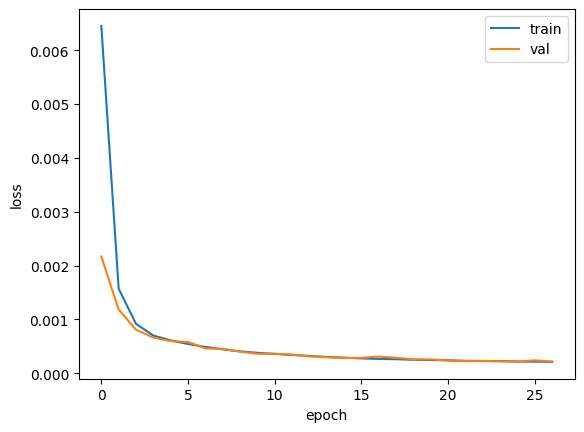

In [ ]:
plt.plot(np.array(epoch_loss))
plt.plot(np.array(epoch_loss_val))
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 3.3 Performance on test set

In [ ]:
loaded_model = Autoencoder(input_dim=X_filled.shape[1])

# Load the state dictionary
loaded_model.load_state_dict(torch.load(f"autoencoder_epoch_{best_epoch + 1}.pth"))

# Move the loaded model to the desired device (CPU or GPU)
loaded_model.to(device)

# Now you can use the loaded_model for inference or further training
# For example, set it to evaluation mode if you are doing inference
loaded_model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=520, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=520, bias=True)
  )
)

In [ ]:
mask_test = !~torch.isnan(X_test).float()
X_test_filled = torch.nan_to_num(X_test, nan = 0.0).float()

output_test = loaded_model(X_test_filled.to(device))
error = criterion(output_test.cpu(), X_test_filled)
point_error = torch.mean(error, dim=1)

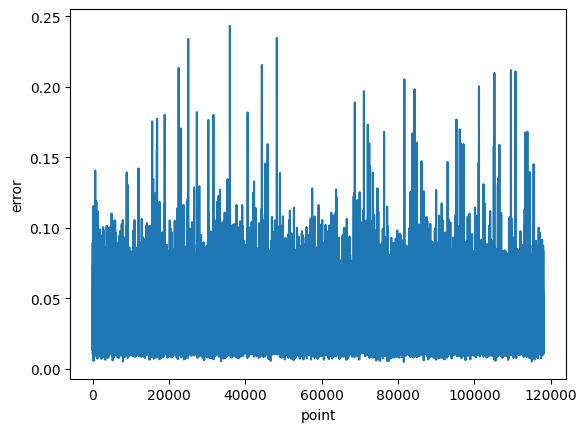

In [ ]:
plt.plot(point_error.detach().numpy())
plt.xlabel('point')
plt.ylabel('error')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

'''
# Make sure they are on CPU and convert to numpy arrays if necessary for sklearn
y_true_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test
y_pred_np = pred_fraud.cpu().numpy() if isinstance(pred_fraud, torch.Tensor) else pred_fraud

# Calculate the confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np)

print("Confusion Matrix:")
print(cm)

# The confusion matrix is typically structured as:
# [[True Negatives (TN), False Positives (FP)]
#  [False Negatives (FN), True Positives (TP)]]

# You can extract these values:
tn, fp, fn, tp = cm.ravel()

print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")'''

'\n# Make sure they are on CPU and convert to numpy arrays if necessary for sklearn\ny_true_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test\ny_pred_np = pred_fraud.cpu().numpy() if isinstance(pred_fraud, torch.Tensor) else pred_fraud\n\n# Calculate the confusion matrix\ncm = confusion_matrix(y_true_np, y_pred_np)\n\nprint("Confusion Matrix:")\nprint(cm)\n\n# The confusion matrix is typically structured as:\n# [[True Negatives (TN), False Positives (FP)]\n#  [False Negatives (FN), True Positives (TP)]]\n\n# You can extract these values:\ntn, fp, fn, tp = cm.ravel()\n\nprint(f"\nTrue Negatives (TN): {tn}")\nprint(f"False Positives (FP): {fp}")\nprint(f"False Negatives (FN): {fn}")\nprint(f"True Positives (TP): {tp}")'

In [ ]:
for threshold in np.arange(0.05, 0.2, 0.01):
    pred_fraud = torch.where(point_error > threshold, 1, 0) # if > threshold, mark as 1, else mark as 0
    print(f"threshold: {threshold:.2f}")
    print(confusion_matrix(y_test.cpu().numpy(), pred_fraud.cpu().numpy()))
    print(f"f1: {f1_score(y_test.cpu().numpy(), pred_fraud.cpu().numpy())}")


threshold: 0.05
[[105752   8223]
 [  3960    173]]
f1: 0.02761593103998723
threshold: 0.06
[[110716   3259]
 [  4059     74]]
f1: 0.01982319849986606
threshold: 0.07
[[112395   1580]
 [  4103     30]]
f1: 0.010447501305937664
threshold: 0.08
[[113212    763]
 [  4109     24]]
f1: 0.00975609756097561
threshold: 0.09
[[113587    388]
 [  4120     13]]
f1: 0.005734450816056462
threshold: 0.10
[[113773    202]
 [  4125      8]]
f1: 0.0036840893391664746
threshold: 0.11
[[113866    109]
 [  4129      4]]
f1: 0.0018841262364578427
threshold: 0.12
[[113904     71]
 [  4131      2]]
f1: 0.0009510223490252021
threshold: 0.13
[[113922     53]
 [  4131      2]]
f1: 0.0009551098376313276
threshold: 0.14
[[113932     43]
 [  4132      1]]
f1: 0.00047881254488867607
threshold: 0.15
[[113940     35]
 [  4132      1]]
f1: 0.0004797313504437515
threshold: 0.16
[[113945     30]
 [  4133      0]]
f1: 0.0
threshold: 0.17
[[113952     23]
 [  4133      0]]
f1: 0.0
threshold: 0.18
[[113958     17]
 [  4133 

If need to clear up cached memory

In [ ]:
import gc
import torch

# Example: assuming you have a large tensor 'large_tensor' on the GPU
# del large_tensor

# Run Python's garbage collector
gc.collect()

# Empty the PyTorch CUDA cache
torch.cuda.empty_cache()

print("GPU memory freed.")

GPU memory freed.


To load a saved model state, you can do the following: